# Import Libraries

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf

In [124]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data

In [125]:
company = '^FCHI' # Symbol of CAC40
#company = 'BTC-USD'

start = dt.datetime(1990,3,1)
#start = dt.datetime(2014, 9, 17)
today = dt.datetime.now()

df = yf.download(company, start = start, end=today)

[*********************100%%**********************]  1 of 1 completed


In [126]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-03-01,1836.0,1838.0,1827.0,1832.0,1832.0,0
1990-03-02,1831.0,1860.0,1831.0,1860.0,1860.0,0
1990-03-05,1866.0,1874.0,1862.0,1874.0,1874.0,0
1990-03-06,1869.0,1875.0,1866.0,1872.0,1872.0,0
1990-03-07,1874.0,1881.0,1874.0,1880.0,1880.0,0


In [127]:
close_train = df["Close"]["2000-01-03":"2018-12-31"] / 1e6
#close_train = df["Close"]["2014-09-17":"2018-12-31"] / 1e6
close_valid = df["Close"]["2019-01-01":"2021-05-31"] / 1e6
close_test = df["Close"]["2021-06-01":] / 1e6

In [128]:
seq_length = 50
#seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    close_train.to_numpy(),
    targets=close_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    close_valid.to_numpy(),
    targets=close_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

# Linear model

In [129]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.99)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=1000,
                    callbacks=[early_stopping_cb])

Epoch 1/1000
151/151 [==============================] - 1s 4ms/step - loss: 6.4042e-07 - mae: 9.6599e-04 - val_loss: 1.3648e-07 - val_mae: 4.3132e-04
Epoch 2/1000
151/151 [==============================] - 0s 1ms/step - loss: 2.0898e-07 - mae: 5.2156e-04 - val_loss: 1.2610e-07 - val_mae: 4.0386e-04
Epoch 3/1000
151/151 [==============================] - 0s 1ms/step - loss: 1.3125e-07 - mae: 4.1025e-04 - val_loss: 3.5778e-07 - val_mae: 7.8830e-04
Epoch 4/1000
151/151 [==============================] - 0s 1ms/step - loss: 1.1180e-07 - mae: 3.7887e-04 - val_loss: 2.6035e-07 - val_mae: 6.6191e-04
Epoch 5/1000
151/151 [==============================] - 0s 1ms/step - loss: 1.0859e-07 - mae: 3.7199e-04 - val_loss: 2.4169e-07 - val_mae: 6.3427e-04
Epoch 6/1000
151/151 [==============================] - 0s 1ms/step - loss: 1.0662e-07 - mae: 3.6881e-04 - val_loss: 2.4381e-07 - val_mae: 6.3757e-04
Epoch 7/1000
151/151 [==============================] - 0s 1ms/step - loss: 1.0579e-07 - mae: 3.6758

In [130]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

18/18 [==============================] - 0s 1ms/step - loss: 1.2610e-07 - mae: 4.0386e-04


403.85668398812413

# Simple RNN

In [131]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [132]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=1000):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae","mse"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae,valid_mse = model.evaluate(valid_set)
    return valid_mae * 1e6, valid_mse *1e6

In [133]:
# BEST LEARNING RATE  = 150 * 0.001 + 0.002

#min_learning_rate = 0.002
#max_learning_rate = 0.2
#step = 0.001

#Mae = []

#for learning_rate in np.arange(min_learning_rate, max_learning_rate + step, step):
#    mae = fit_and_evaluate(model, train_ds, valid_ds, learning_rate=learning_rate)
#    Mae.append(mae)
    

#for mae in Mae :
#    print(mae)

#plt.plot(Mae)
#plt.show()
    
mae_rnn, mse_rnn = fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.152)

Epoch 1/1000
151/151 [==============================] - 1s 5ms/step - loss: 0.4919 - mae: 0.9898 - mse: 0.9838 - val_loss: 0.4946 - val_mae: 0.9946 - val_mse: 0.9892
Epoch 2/1000
151/151 [==============================] - 1s 4ms/step - loss: 0.4956 - mae: 0.9956 - mse: 0.9913 - val_loss: 0.4946 - val_mae: 0.9946 - val_mse: 0.9892
Epoch 3/1000
151/151 [==============================] - 1s 4ms/step - loss: 0.4956 - mae: 0.9956 - mse: 0.9913 - val_loss: 0.4946 - val_mae: 0.9946 - val_mse: 0.9892
Epoch 4/1000
151/151 [==============================] - 1s 4ms/step - loss: 0.4956 - mae: 0.9956 - mse: 0.9913 - val_loss: 0.4946 - val_mae: 0.9946 - val_mse: 0.9892
Epoch 5/1000
151/151 [==============================] - 1s 4ms/step - loss: 0.4956 - mae: 0.9956 - mse: 0.9913 - val_loss: 0.4946 - val_mae: 0.9946 - val_mse: 0.9892
Epoch 6/1000
151/151 [==============================] - 1s 4ms/step - loss: 0.4956 - mae: 0.9956 - mse: 0.9913 - val_loss: 0.4946 - val_mae: 0.9946 - val_mse: 0.9892
Epoc

In [134]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [135]:
# CHECK LEARNING RATE AFTER 150 * 0.001 + 0.002

#min_learning_rate = 0.002
#max_learning_rate = 0.2
#step = 0.001

#Mae = []

#for learning_rate in np.arange(min_learning_rate, max_learning_rate + step, step):
#    mae = fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=learning_rate)
#    Mae.append(mae)
    

#for mae in Mae :
#    print(mae)

#plt.plot(Mae)
#plt.show()

# extra code – compiles, fits, and evaluates the model, like earlier
mae_univar, mse_univar = fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.152, epochs=2000)

Epoch 1/2000
151/151 [==============================] - 2s 6ms/step - loss: 6.6095 - mae: 6.9090 - mse: 120.3827 - val_loss: 28.1834 - val_mae: 28.6834 - val_mse: 822.7390
Epoch 2/2000
151/151 [==============================] - 1s 5ms/step - loss: 15.8957 - mae: 16.3865 - mse: 399.2704 - val_loss: 43.3148 - val_mae: 43.8148 - val_mse: 1919.7407
Epoch 3/2000
151/151 [==============================] - 1s 5ms/step - loss: 13.2887 - mae: 13.7781 - mse: 344.3161 - val_loss: 6.9891 - val_mae: 7.4891 - val_mse: 56.0867
Epoch 4/2000
151/151 [==============================] - 1s 5ms/step - loss: 12.9470 - mae: 13.4376 - mse: 241.8472 - val_loss: 12.6275 - val_mae: 13.1275 - val_mse: 172.3303
Epoch 5/2000
151/151 [==============================] - 1s 5ms/step - loss: 23.4828 - mae: 23.9791 - mse: 850.0773 - val_loss: 1.8816 - val_mae: 2.3816 - val_mse: 5.6720
Epoch 6/2000
151/151 [==============================] - 1s 4ms/step - loss: 9.7405 - mae: 10.2290 - mse: 152.3460 - val_loss: 5.7678 - val

# Deep RNN

In [136]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [137]:
# BEST LEARNING_RATE = 25 * 0.001 + 0.002

#min_learning_rate = 0.002
#max_learning_rate = 0.2
#step = 0.001

#Mae = []

#for learning_rate in np.arange(min_learning_rate, max_learning_rate + step, step):
#    mae = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=learning_rate)
#    Mae.append(mae)
    

#for mae in Mae :
#    print(mae)

#plt.plot(Mae)
#plt.show()

# extra code – compiles, fits, and evaluates the model, like earlier
mae_deep, mse_deep = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.0027)

Epoch 1/1000
151/151 [==============================] - 4s 15ms/step - loss: 0.0123 - mae: 0.1225 - mse: 0.0247 - val_loss: 0.0052 - val_mae: 0.1015 - val_mse: 0.0103
Epoch 2/1000
151/151 [==============================] - 2s 13ms/step - loss: 0.0014 - mae: 0.0461 - mse: 0.0028 - val_loss: 0.0012 - val_mae: 0.0485 - val_mse: 0.0024
Epoch 3/1000
151/151 [==============================] - 2s 13ms/step - loss: 2.9831e-04 - mae: 0.0215 - mse: 5.9662e-04 - val_loss: 2.3107e-04 - val_mae: 0.0215 - val_mse: 4.6214e-04
Epoch 4/1000
151/151 [==============================] - 2s 13ms/step - loss: 6.6708e-05 - mae: 0.0101 - mse: 1.3342e-04 - val_loss: 6.4877e-05 - val_mae: 0.0114 - val_mse: 1.2975e-04
Epoch 5/1000
151/151 [==============================] - 2s 13ms/step - loss: 1.5280e-05 - mae: 0.0048 - mse: 3.0560e-05 - val_loss: 7.7298e-06 - val_mae: 0.0039 - val_mse: 1.5460e-05
Epoch 6/1000
151/151 [==============================] - 2s 13ms/step - loss: 3.9203e-06 - mae: 0.0024 - mse: 7.8407e-

# Multivariate time series

In [138]:
df_mulvar = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_close"] = df["Close"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [139]:
mulvar_train = df_mulvar["1990-03-01":"2018-12-31"]
#mulvar_train = df_mulvar["2014-09-17":"2018-12-31"]
mulvar_valid = df_mulvar["2019-01-01":"2021-05-31"]
mulvar_test = df_mulvar["2021-06-01":]

In [140]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["Close"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["Close"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [141]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 7]),
    tf.keras.layers.Dense(1)
])

In [142]:
# LEARNING_RATE A REFAIRE ENTRE 0 ET 100 * 0.001 + 0.002

#min_learning_rate = 0.002
#max_learning_rate = 0.2
#step = 0.001

#Mae = []

#for learning_rate in np.arange(min_learning_rate, max_learning_rate + step, step):
#    mae = fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=learning_rate)
#    Mae.append(mae)
    

#for mae in Mae :
#    print(mae)

#plt.plot(Mae)
#plt.show()

# extra code – compiles, fits, and evaluates the model, like earlier
mae_mul, mse_mul = fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.102)

Epoch 1/1000
227/227 [==============================] - 2s 5ms/step - loss: 9.5922 - mae: 10.0857 - mse: 158.0541 - val_loss: 13.0077 - val_mae: 13.5077 - val_mse: 182.4574
Epoch 2/1000
227/227 [==============================] - 1s 5ms/step - loss: 23.0803 - mae: 23.5774 - mse: 770.7057 - val_loss: 18.1152 - val_mae: 18.6152 - val_mse: 346.5242
Epoch 3/1000
227/227 [==============================] - 1s 5ms/step - loss: 12.2490 - mae: 12.7417 - mse: 225.6082 - val_loss: 6.9458 - val_mae: 7.4458 - val_mse: 55.4395
Epoch 4/1000
227/227 [==============================] - 1s 5ms/step - loss: 44.0499 - mae: 44.5461 - mse: 2966.0437 - val_loss: 55.5161 - val_mae: 56.0161 - val_mse: 3137.8069
Epoch 5/1000
227/227 [==============================] - 1s 4ms/step - loss: 20.1626 - mae: 20.6597 - mse: 638.6945 - val_loss: 12.2269 - val_mae: 12.7269 - val_mse: 161.9733
Epoch 6/1000
227/227 [==============================] - 1s 4ms/step - loss: 8.5609 - mae: 9.0503 - mse: 128.6754 - val_loss: 0.4350 

# Forecasting Several Steps Ahead

In [143]:
import numpy as np

X = close_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 16ms/step


C:\Users\leamd\anaconda3\envs\tensorflow-gpu\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
C:\Users\leamd\anaconda3\envs\tensorflow-gpu\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
C:\Users\leamd\anaconda3\envs\tensorflow-gpu\Lib\site-packages\matplotlib\axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return self.major.locator()
C:\Users\leamd\anaconda3\envs\tensorflow-gpu\Lib\site-packages\matplotlib\axis.py:1495: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq=

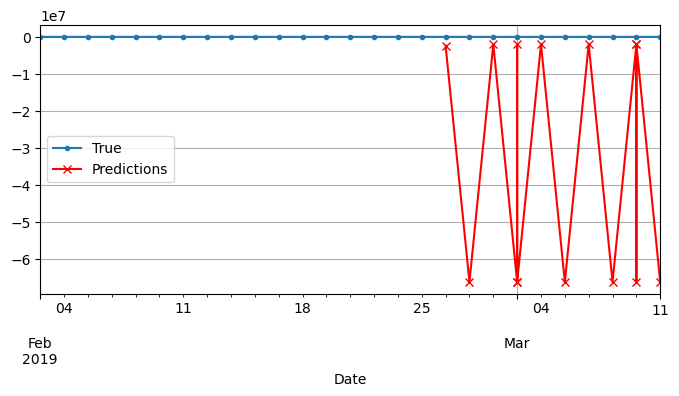

In [144]:
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(close_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
plt.show()

In [145]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [146]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 7]),
    tf.keras.layers.Dense(14)
])

In [147]:
# BEST LEARNING_RATE = 150 * 0.001 + 0.002 BUT STILL SUCKS

#min_learning_rate = 0.002
#max_learning_rate = 0.2
#step = 0.001

#Mae = []

#for learning_rate in np.arange(min_learning_rate, max_learning_rate + step, step):
#    mae = fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, learning_rate=learning_rate)
#    Mae.append(mae)
    

#for mae in Mae :
#    print(mae)

#plt.plot(Mae)
#plt.show()


mae_ahead, mse_ahead = fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.152)

Epoch 1/1000
227/227 [==============================] - 2s 5ms/step - loss: 0.1044 - mae: 0.2893 - mse: 0.2390 - val_loss: 0.0323 - val_mae: 0.1767 - val_mse: 0.0645
Epoch 2/1000
227/227 [==============================] - 1s 4ms/step - loss: 0.0114 - mae: 0.0908 - mse: 0.0228 - val_loss: 0.0035 - val_mae: 0.0557 - val_mse: 0.0071
Epoch 3/1000
227/227 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0290 - mse: 0.0023 - val_loss: 3.7054e-04 - val_mae: 0.0172 - val_mse: 7.4107e-04
Epoch 4/1000
227/227 [==============================] - 1s 4ms/step - loss: 1.1886e-04 - mae: 0.0094 - mse: 2.3772e-04 - val_loss: 3.5707e-05 - val_mae: 0.0058 - val_mse: 7.1414e-05
Epoch 5/1000
227/227 [==============================] - 1s 4ms/step - loss: 1.1883e-05 - mae: 0.0033 - mse: 2.3766e-05 - val_loss: 3.9297e-06 - val_mae: 0.0020 - val_mse: 7.8594e-06
Epoch 6/1000
227/227 [==============================] - 1s 4ms/step - loss: 2.6945e-06 - mae: 0.0018 - mse: 5.3891e-06 - val_loss:

In [148]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 7]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 116ms/step


# Deep RNNs with Layer Norm

In [201]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [202]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [203]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [152]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [153]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 7]),
    tf.keras.layers.Dense(14)
])

In [154]:
#BEST LEARNING_RATE = 0.002 + 160 * 0.001

#min_learning_rate = 0.002
#max_learning_rate = 0.2
#step = 0.001

#Mae = []

#for learning_rate in np.arange(min_learning_rate, max_learning_rate + step, step):
#    mae = fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid, learning_rate=learning_rate)
#    Mae.append(mae)
    

#for mae in Mae :
#    print(mae)

#plt.plot(Mae)
#plt.show()

mae_cstm, mse_cstm = fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.162, epochs=10000)

Epoch 1/10000
227/227 [==============================] - 5s 16ms/step - loss: 0.0307 - mae: 0.1715 - mse: 0.0615 - val_loss: 0.0044 - val_mae: 0.0765 - val_mse: 0.0088
Epoch 2/10000
227/227 [==============================] - 3s 15ms/step - loss: 0.0023 - mae: 0.0477 - mse: 0.0046 - val_loss: 5.1204e-04 - val_mae: 0.0251 - val_mse: 0.0010
Epoch 3/10000
227/227 [==============================] - 3s 15ms/step - loss: 2.2726e-04 - mae: 0.0152 - mse: 4.5453e-04 - val_loss: 9.4336e-05 - val_mae: 0.0092 - val_mse: 1.8867e-04
Epoch 4/10000
227/227 [==============================] - 3s 15ms/step - loss: 2.7526e-05 - mae: 0.0052 - mse: 5.5052e-05 - val_loss: 5.9280e-06 - val_mae: 0.0027 - val_mse: 1.1856e-05
Epoch 5/10000
227/227 [==============================] - 3s 15ms/step - loss: 5.2727e-06 - mae: 0.0024 - mse: 1.0545e-05 - val_loss: 8.5937e-07 - val_mae: 0.0010 - val_mse: 1.7187e-06
Epoch 6/10000
227/227 [==============================] - 3s 15ms/step - loss: 2.4783e-06 - mae: 0.0017 - mse

# LSTM

In [155]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 7]),
    tf.keras.layers.Dense(14)
])

In [156]:
# BEST LEARNING_RATE = 15 * 0.01 + 0.01

#min_learning_rate = 0.01
#max_learning_rate = 0.2
#step = 0.01

#Mae = []

#for learning_rate in np.arange(min_learning_rate, max_learning_rate + step, step):
#    mae = fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid, learning_rate=learning_rate)
#    Mae.append(mae)
    

#for mae in Mae :
#    print(mae)

#plt.plot(Mae)
#plt.show()


mae_lstm, mse_lstm = fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.16)

Epoch 1/1000
227/227 [==============================] - 5s 14ms/step - loss: 0.0374 - mae: 0.1708 - mse: 0.0765 - val_loss: 0.0100 - val_mae: 0.1106 - val_mse: 0.0201
Epoch 2/1000
227/227 [==============================] - 3s 12ms/step - loss: 0.0037 - mae: 0.0540 - mse: 0.0075 - val_loss: 4.7747e-04 - val_mae: 0.0246 - val_mse: 9.5493e-04
Epoch 3/1000
227/227 [==============================] - 3s 12ms/step - loss: 3.8108e-04 - mae: 0.0174 - mse: 7.6215e-04 - val_loss: 2.9897e-05 - val_mae: 0.0061 - val_mse: 5.9793e-05
Epoch 4/1000
227/227 [==============================] - 3s 12ms/step - loss: 4.0077e-05 - mae: 0.0057 - mse: 8.0153e-05 - val_loss: 6.1576e-06 - val_mae: 0.0025 - val_mse: 1.2315e-05
Epoch 5/1000
227/227 [==============================] - 3s 12ms/step - loss: 5.5246e-06 - mae: 0.0023 - mse: 1.1049e-05 - val_loss: 3.7419e-06 - val_mae: 0.0022 - val_mse: 7.4838e-06
Epoch 6/1000
227/227 [==============================] - 3s 13ms/step - loss: 1.1369e-06 - mae: 0.0013 - mse: 

# GRU

In [157]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 7]),
    tf.keras.layers.Dense(14)
])

In [158]:
# BEST LEARNING_RATE = 15 * 0.01 + 0.15

#min_learning_rate = 0.15
#max_learning_rate = 0.4
#step = 0.01

#Mae = []

#for learning_rate in np.arange(min_learning_rate, max_learning_rate + step, step):
#    mae = fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid, learning_rate=learning_rate)
#    Mae.append(mae)
    

#for mae in Mae :
#    print(mae)

#plt.plot(Mae)
#plt.show()

mae_gru, mse_gru = fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.3)

Epoch 1/1000
227/227 [==============================] - 5s 14ms/step - loss: 0.0793 - mae: 0.3010 - mse: 0.1602 - val_loss: 0.0227 - val_mae: 0.1898 - val_mse: 0.0453
Epoch 2/1000
227/227 [==============================] - 3s 12ms/step - loss: 0.0080 - mae: 0.0958 - mse: 0.0161 - val_loss: 0.0022 - val_mae: 0.0579 - val_mse: 0.0044
Epoch 3/1000
227/227 [==============================] - 3s 12ms/step - loss: 8.1523e-04 - mae: 0.0306 - mse: 0.0016 - val_loss: 2.0839e-04 - val_mae: 0.0177 - val_mse: 4.1679e-04
Epoch 4/1000
227/227 [==============================] - 3s 13ms/step - loss: 8.7836e-05 - mae: 0.0099 - mse: 1.7567e-04 - val_loss: 2.3845e-05 - val_mae: 0.0058 - val_mse: 4.7690e-05
Epoch 5/1000
227/227 [==============================] - 3s 12ms/step - loss: 8.7610e-06 - mae: 0.0032 - mse: 1.7522e-05 - val_loss: 1.9529e-06 - val_mae: 0.0017 - val_mse: 3.9058e-06
Epoch 6/1000
227/227 [==============================] - 3s 13ms/step - loss: 2.5133e-06 - mae: 0.0017 - mse: 5.0265e-06 -

# Using One-Dimensional Convolutional Layers to Process Sequences

In [181]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 7]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [186]:
mae_conv, mse_conv = fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.185)

Epoch 1/1000
225/225 [==============================] - 5s 16ms/step - loss: 1.1005e-06 - mae: 0.0011 - mse: 2.2009e-06 - val_loss: 4.4812e-07 - val_mae: 7.6977e-04 - val_mse: 8.9623e-07
Epoch 2/1000
225/225 [==============================] - 3s 14ms/step - loss: 1.3724e-06 - mae: 0.0013 - mse: 2.7448e-06 - val_loss: 5.4277e-07 - val_mae: 9.3236e-04 - val_mse: 1.0855e-06
Epoch 3/1000
225/225 [==============================] - 3s 13ms/step - loss: 9.8345e-07 - mae: 0.0011 - mse: 1.9669e-06 - val_loss: 4.1591e-07 - val_mae: 8.0759e-04 - val_mse: 8.3182e-07
Epoch 4/1000
225/225 [==============================] - 3s 13ms/step - loss: 1.1471e-06 - mae: 0.0013 - mse: 2.2941e-06 - val_loss: 4.9488e-07 - val_mae: 8.8823e-04 - val_mse: 9.8976e-07
Epoch 5/1000
225/225 [==============================] - 3s 13ms/step - loss: 9.2404e-07 - mae: 0.0011 - mse: 1.8481e-06 - val_loss: 2.5370e-07 - val_mae: 6.1366e-04 - val_mse: 5.0741e-07
Epoch 6/1000
225/225 [==============================] - 3s 13ms/s

KeyboardInterrupt: 

In [161]:
print(mae_conv)
print(mse_conv)

394.334812881425
0.2551224440594524


# WaveNet - Bis

In [162]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [163]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [164]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 3  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 7])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

In [165]:
# BEST LEARNING_RATE = 30 * 0.01 + 0.15

#min_learning_rate = 0.15
#max_learning_rate = 0.5
#step = 0.01

#Mae = []

#for learning_rate in np.arange(min_learning_rate, max_learning_rate + step, step):
#    mae = fit_and_evaluate(full_wavenet_model, longer_train, longer_valid, learning_rate=learning_rate)
#    Mae.append(mae)
    

#for mae in Mae :
#    print(mae)

#plt.plot(Mae)
#plt.show()


mae_wave, mse_wave = fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.4)

Epoch 1/1000
225/225 [==============================] - 3s 9ms/step - loss: 1.4024e-04 - mae: 0.0129 - mse: 2.8047e-04 - val_loss: 4.4277e-06 - val_mae: 0.0026 - val_mse: 8.8553e-06
Epoch 2/1000
225/225 [==============================] - 2s 8ms/step - loss: 1.3469e-05 - mae: 0.0041 - mse: 2.6939e-05 - val_loss: 2.8114e-06 - val_mae: 0.0022 - val_mse: 5.6228e-06
Epoch 3/1000
225/225 [==============================] - 2s 7ms/step - loss: 2.6922e-06 - mae: 0.0017 - mse: 5.3845e-06 - val_loss: 7.7415e-07 - val_mae: 0.0010 - val_mse: 1.5483e-06
Epoch 4/1000
225/225 [==============================] - 2s 7ms/step - loss: 1.7981e-06 - mae: 0.0014 - mse: 3.5961e-06 - val_loss: 2.5035e-07 - val_mae: 5.6344e-04 - val_mse: 5.0069e-07
Epoch 5/1000
225/225 [==============================] - 2s 7ms/step - loss: 1.5759e-06 - mae: 0.0013 - mse: 3.1518e-06 - val_loss: 1.6335e-07 - val_mae: 4.3668e-04 - val_mse: 3.2670e-07
Epoch 6/1000
225/225 [==============================] - 2s 7ms/step - loss: 1.5526

# LSTM - Version youtube

In [166]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
yt_model1 = tf.keras.Sequential([
    #tf.keras.layers.LSTM(200, return_sequences=True, input_shape=[None, 7]),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.LSTM(200),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(14)
    
    tf.keras.layers.GRU(200, return_sequences=True, input_shape=[None, 7]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(200, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(200, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(14)
])

In [167]:
mae_yt1, mse_yt1 = fit_and_evaluate(yt_model1, seq2seq_train, seq2seq_valid,
                 learning_rate=0.3)

Epoch 1/1000
227/227 [==============================] - 72s 301ms/step - loss: 0.0236 - mae: 0.1508 - mse: 0.0477 - val_loss: 8.0748e-04 - val_mae: 0.0330 - val_mse: 0.0016
Epoch 2/1000
227/227 [==============================] - 68s 298ms/step - loss: 6.2208e-04 - mae: 0.0259 - mse: 0.0012 - val_loss: 1.3895e-05 - val_mae: 0.0042 - val_mse: 2.7790e-05
Epoch 3/1000
227/227 [==============================] - 67s 294ms/step - loss: 6.7591e-05 - mae: 0.0088 - mse: 1.3518e-04 - val_loss: 2.5209e-06 - val_mae: 0.0019 - val_mse: 5.0417e-06
Epoch 4/1000
227/227 [==============================] - 67s 297ms/step - loss: 2.5623e-05 - mae: 0.0054 - mse: 5.1245e-05 - val_loss: 2.0718e-06 - val_mae: 0.0016 - val_mse: 4.1436e-06
Epoch 5/1000
227/227 [==============================] - 69s 303ms/step - loss: 1.6217e-05 - mae: 0.0043 - mse: 3.2434e-05 - val_loss: 1.5830e-06 - val_mae: 0.0015 - val_mse: 3.1661e-06
Epoch 6/1000
227/227 [==============================] - 68s 301ms/step - loss: 1.2724e-05 -

In [168]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
yt_model2 = tf.keras.Sequential([
    
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu", input_shape=[None, 7]),
    tf.keras.layers.GRU(32, return_sequences=True),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
])

In [169]:
mae_yt2, mse_yt2 = fit_and_evaluate(yt_model2, downsampled_train, downsampled_valid,
                 learning_rate=0.25)

Epoch 1/1000
225/225 [==============================] - 5s 15ms/step - loss: 0.0760 - mae: 0.2893 - mse: 0.1534 - val_loss: 0.0221 - val_mae: 0.1651 - val_mse: 0.0442
Epoch 2/1000
225/225 [==============================] - 3s 13ms/step - loss: 0.0077 - mae: 0.0920 - mse: 0.0154 - val_loss: 0.0018 - val_mae: 0.0481 - val_mse: 0.0037
Epoch 3/1000
225/225 [==============================] - 3s 14ms/step - loss: 8.1287e-04 - mae: 0.0299 - mse: 0.0016 - val_loss: 1.6937e-04 - val_mae: 0.0133 - val_mse: 3.3874e-04
Epoch 4/1000
225/225 [==============================] - 3s 14ms/step - loss: 8.4413e-05 - mae: 0.0096 - mse: 1.6883e-04 - val_loss: 1.7954e-05 - val_mae: 0.0043 - val_mse: 3.5909e-05
Epoch 5/1000
225/225 [==============================] - 3s 14ms/step - loss: 9.6205e-06 - mae: 0.0034 - mse: 1.9241e-05 - val_loss: 3.0611e-06 - val_mae: 0.0020 - val_mse: 6.1221e-06
Epoch 6/1000
225/225 [==============================] - 3s 14ms/step - loss: 2.2168e-06 - mae: 0.0016 - mse: 4.4337e-06 -

In [170]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
yt_model3 = tf.keras.Sequential([
    
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu", input_shape=[None, 7]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
])

In [171]:
mae_yt3, mse_yt3 = fit_and_evaluate(yt_model3, downsampled_train, downsampled_valid,
                 learning_rate=0.1)

Epoch 1/1000
225/225 [==============================] - 5s 16ms/step - loss: 0.0865 - mae: 0.3240 - mse: 0.1754 - val_loss: 0.0102 - val_mae: 0.1178 - val_mse: 0.0205
Epoch 2/1000
225/225 [==============================] - 3s 14ms/step - loss: 0.0114 - mae: 0.1158 - mse: 0.0228 - val_loss: 0.0011 - val_mae: 0.0381 - val_mse: 0.0021
Epoch 3/1000
225/225 [==============================] - 3s 14ms/step - loss: 0.0012 - mae: 0.0377 - mse: 0.0024 - val_loss: 1.1768e-04 - val_mae: 0.0127 - val_mse: 2.3537e-04
Epoch 4/1000
225/225 [==============================] - 3s 14ms/step - loss: 1.2469e-04 - mae: 0.0122 - mse: 2.4937e-04 - val_loss: 1.1707e-05 - val_mae: 0.0039 - val_mse: 2.3413e-05
Epoch 5/1000
225/225 [==============================] - 3s 14ms/step - loss: 1.4766e-05 - mae: 0.0042 - mse: 2.9532e-05 - val_loss: 3.5730e-06 - val_mae: 0.0024 - val_mse: 7.1460e-06
Epoch 6/1000
225/225 [==============================] - 3s 14ms/step - loss: 2.2378e-06 - mae: 0.0017 - mse: 4.4757e-06 - val

# Graphs

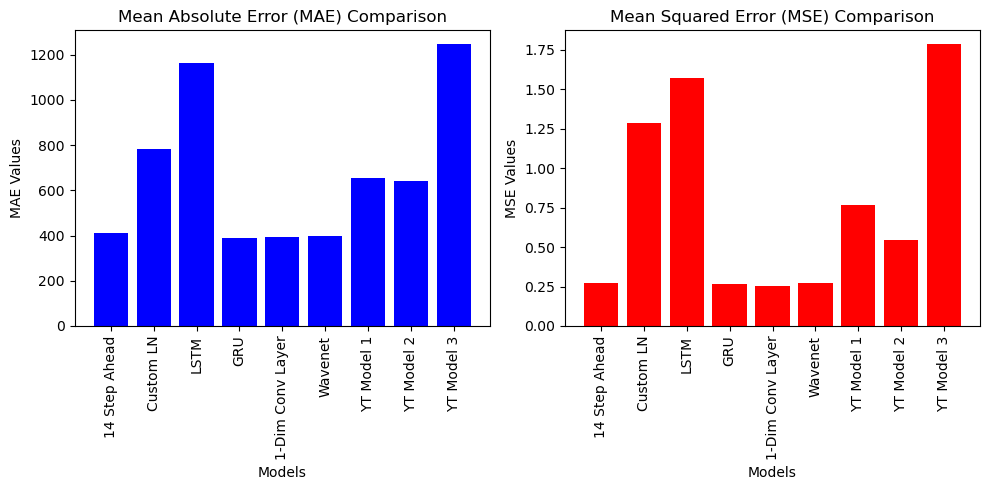

In [176]:
model_data = {
    #'Simple RNN': {'MAE': mae_rnn, 'MSE': mse_rnn},
    #'Univariable': {'MAE': mae_univar, 'MSE': mse_univar},
    #'Deep RNN': {'MAE': mae_deep, 'MSE': mse_deep},
    #'Multivariable': {'MAE': mae_mul, 'MSE': mse_mul},
    '14 Step Ahead': {'MAE': mae_ahead, 'MSE': mse_ahead},
    'Custom LN': {'MAE': mae_cstm, 'MSE': mse_cstm},
    'LSTM': {'MAE': mae_lstm, 'MSE': mse_lstm},
    'GRU': {'MAE': mae_gru, 'MSE': mse_gru},
    '1-Dim Conv Layer': {'MAE': mae_conv, 'MSE': mse_conv},
    'Wavenet': {'MAE': mae_wave, 'MSE': mse_wave},
    'YT Model 1': {'MAE': mae_yt1, 'MSE': mse_yt1},
    'YT Model 2': {'MAE': mae_yt2, 'MSE': mse_yt2},
    'YT Model 3': {'MAE': mae_yt3, 'MSE': mse_yt3}
}

# Extracting model names, MAE values, and MSE values from the dictionary
models = list(model_data.keys())
mae_values = [model_data[model]['MAE'] for model in models]
mse_values = [model_data[model]['MSE'] for model in models]

# Creating bar charts to compare MAE values of different models
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(models, mae_values, color='blue')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.xlabel('Models')
plt.ylabel('MAE Values')
plt.xticks(rotation='vertical') 

# Creating bar charts to compare MSE values of different models
plt.subplot(1, 2, 2)
plt.bar(models, mse_values, color='red')
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE Values')
plt.xticks(rotation='vertical') 

plt.tight_layout()
plt.show()